In [1]:
# Install if not already done (in Colab or local)
%pip install pandas scikit-learn xgboost matplotlib seaborn streamlit --quiet


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [4]:
# Use the raw content URL for the CSV file
url = "https://raw.githubusercontent.com/JoyceBodo/donor-project-prediction/main/donor-funded-projects-in-kenya-per-county-in-line-with-mdgs.csv"

# Read the CSV file with proper handling of irregular delimiters
df = pd.read_csv(url, encoding='latin-1')

# Get the shape of the dataframe
rows, cols = df.shape
print(f'rows {rows}\ncols {cols}')

# Display the columns
df.columns

rows 8114
cols 12


Index(['Unspecified', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [6]:
# Rename columns using the second row
df.columns = df.iloc[1]
df = df[2:].reset_index(drop=True)

# Drop any remaining unnamed columns with mostly missing data
df = df.dropna(axis=1, how='all')

# Rename columns explicitly for clarity
df.columns = [
    "Project_ID", "Project_Title", "Total_Cost_KES", "Funding_Type", "Funding_Source",
    "Start_Date_Planned", "Start_Date_Actual", "Duration_Months", "Vision_2030_Flagship",
    "MTEF_Sector", "Implementing_Agency", "Implementation_Status"
]

# Convert numeric and date columns
df["Total_Cost_KES"] = pd.to_numeric(df["Total_Cost_KES"], errors="coerce")
df["Start_Date_Planned"] = pd.to_datetime(df["Start_Date_Planned"], errors="coerce")
df["Start_Date_Actual"] = pd.to_datetime(df["Start_Date_Actual"], errors="coerce")
df["Duration_Months"] = pd.to_numeric(df["Duration_Months"], errors="coerce")

# Display cleaned dataset info
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8110 entries, 0 to 8109
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project_ID             7228 non-null   object        
 1   Project_Title          6789 non-null   object        
 2   Total_Cost_KES         97 non-null     float64       
 3   Funding_Type           6789 non-null   object        
 4   Funding_Source         6753 non-null   object        
 5   Start_Date_Planned     4299 non-null   datetime64[ns]
 6   Start_Date_Actual      2504 non-null   datetime64[ns]
 7   Duration_Months        138 non-null    float64       
 8   Vision_2030_Flagship   6773 non-null   object        
 9   MTEF_Sector            6789 non-null   object        
 10  Implementing_Agency    6741 non-null   object        
 11  Implementation_Status  6789 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 760.

(None,
     Project_ID                                      Project_Title  \
 0  2010/051501        Construction Of Kyuso District Headquarters   
 1  2010/051502      Construction Of Malindi District Headquarters   
 2  2010/051503        Construction Of Nzaui District Headquarters   
 3  2010/051509      Construction Of Kibwezi District Headquarters   
 4  2010/051517  Construction Of Meru Central District Headquar...   
 
    Total_Cost_KES      Funding_Type       Funding_Source Start_Date_Planned  \
 0             NaN  GoK; Unspecified  Government of Kenya         2008-03-02   
 1             NaN  GoK; Unspecified  Government of Kenya                NaT   
 2             NaN  GoK; Unspecified  Government of Kenya         2008-08-03   
 3             NaN  GoK; Unspecified  Government of Kenya         2009-02-03   
 4             NaN  GoK; Unspecified  Government of Kenya         2009-02-04   
 
   Start_Date_Actual  Duration_Months Vision_2030_Flagship  \
 0        2008-04-02       

In [ ]:
# Data Cleaning & Feature Engineering
# Handle missing values: Drop rows with essential info missing
df = df.dropna(subset=["Project_ID", "Project_Title", "Implementation_Status"])

# Fill numeric columns with median values
df["Total_Cost_KES"] = df["Total_Cost_KES"].fillna(df["Total_Cost_KES"].median())
df["Duration_Months"] = df["Duration_Months"].fillna(df["Duration_Months"].median())

# Fill Start_Date_Actual with Start_Date_Planned where missing
df["Start_Date_Actual"] = df["Start_Date_Actual"].fillna(df["Start_Date_Planned"])

# Define categorical columns and fill missing with 'Unknown'
categorical_cols = ["Funding_Type", "Funding_Source", "Vision_2030_Flagship", "MTEF_Sector", "Implementing_Agency"]
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Remove duplicate records
df = df.drop_duplicates()

# Standardize categorical variables: lowercase and strip spaces
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.lower().str.strip())

# Display final dataset info and missing values count
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 2844 entries, 0 to 8102
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project_ID             2844 non-null   object        
 1   Project_Title          2844 non-null   object        
 2   Total_Cost_KES         2844 non-null   float64       
 3   Funding_Type           2844 non-null   object        
 4   Funding_Source         2844 non-null   object        
 5   Start_Date_Planned     1949 non-null   datetime64[ns]
 6   Start_Date_Actual      2108 non-null   datetime64[ns]
 7   Duration_Months        2844 non-null   float64       
 8   Vision_2030_Flagship   2844 non-null   object        
 9   MTEF_Sector            2844 non-null   object        
 10  Implementing_Agency    2844 non-null   object        
 11  Implementation_Status  2844 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 288.8+ KB

In [10]:
# Fix missing values in date columns
# Fill Start_Date_Planned with the most frequent start date for that funding source
most_common_start_date = df.groupby("Funding_Source")["Start_Date_Planned"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else pd.NaT))
df.loc[:, "Start_Date_Planned"] = most_common_start_date

# Fill Start_Date_Actual with Start_Date_Planned
df.loc[:, "Start_Date_Actual"] = df["Start_Date_Actual"].fillna(df["Start_Date_Planned"])

# If any dates are still missing, fill them with the overall most frequent start date
overall_common_date = df["Start_Date_Planned"].mode()[0] if not df["Start_Date_Planned"].mode().empty else pd.NaT
df.loc[:, "Start_Date_Planned"] = df["Start_Date_Planned"].fillna(overall_common_date)
df.loc[:, "Start_Date_Actual"] = df["Start_Date_Actual"].fillna(overall_common_date)

# Check missing values again
df.isnull().sum()

Project_ID               0
Project_Title            0
Total_Cost_KES           0
Funding_Type             0
Funding_Source           0
Start_Date_Planned       0
Start_Date_Actual        0
Duration_Months          0
Vision_2030_Flagship     0
MTEF_Sector              0
Implementing_Agency      0
Implementation_Status    0
dtype: int64

In [11]:
# Save the cleaned dataset to a new CSV file
cleaned_file_path = "https://github.com/JoyceBodo/donor-project-prediction/blob/main/donor_projects_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)

# Return the file path for download
cleaned_file_path

'https://github.com/JoyceBodo/donor-project-prediction/blob/main/donor_projects_cleaned.csv'

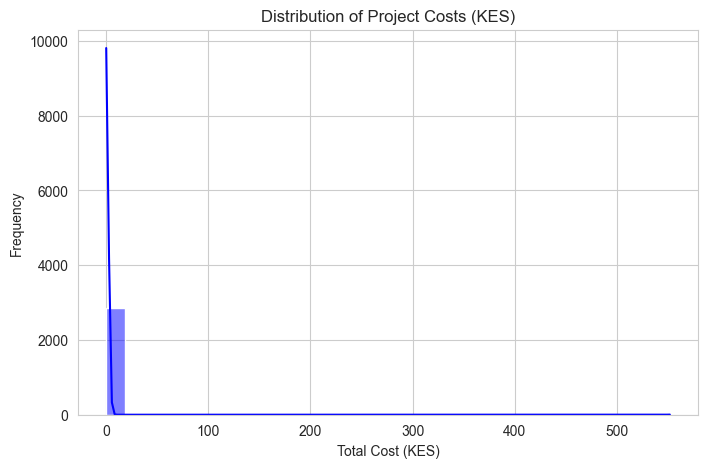

(       Total_Cost_KES             Start_Date_Planned  \
 count     2844.000000                           2844   
 mean         0.221519  2011-01-06 15:17:58.481012736   
 min          0.000000            1954-06-07 00:00:00   
 25%          0.000000            2010-04-09 18:00:00   
 50%          0.000000            2010-07-01 00:00:00   
 75%          0.000000            2012-07-02 00:00:00   
 max        552.000000            2015-11-01 00:00:00   
 std         10.429443                            NaN   
 
                    Start_Date_Actual  Duration_Months  
 count                           2844           2844.0  
 mean   2011-02-15 00:11:38.734177024              0.0  
 min              1983-01-01 00:00:00              0.0  
 25%              2010-04-06 00:00:00              0.0  
 50%              2010-07-12 00:00:00              0.0  
 75%              2012-09-01 00:00:00              0.0  
 max              2015-11-01 00:00:00              0.0  
 std                         

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Summary statistics for numerical columns
numerical_summary = df.describe()

# Distribution of categorical variables
categorical_summary = {col: df[col].value_counts() for col in ["Funding_Type", "Funding_Source", "Implementation_Status"]}

# Plot distribution of project costs
plt.figure(figsize=(8, 5))
sns.histplot(df["Total_Cost_KES"], bins=30, kde=True, color="blue")
plt.title("Distribution of Project Costs (KES)")
plt.xlabel("Total Cost (KES)")
plt.ylabel("Frequency")
plt.show()

# Return summaries
numerical_summary, categorical_summary

Histogram: Distribution of Project Costs (KES)
Observations:
The X-axis represents project costs (Total_Cost_KES), and the Y-axis shows the frequency.
The chart is highly right-skewed: almost all values are clustered near 0, and only a few outliers go as high as KES 552 million.
This kind of distribution is common in funding data, where most projects are small and a few are very large.

The summary statistics has a median at 75% = 0.00 suggests most projects have zero recorded cost, possibly due to:Data entry errors, Incomplete reporting

The Mean (0.22) is misleading due to extreme outliers (like the 552M value).We will carry out log-transform or filter out zero or extreme values for better modeling and visualisation.

The Duration_Months column which shows that all durations are zero suggests that this column is not populated correctly. Therefore for the next step we will recalculate duration as End Date - Start Date or we can drop or ignore this column if it's not usable

The Start_Date_Planned & Start_Date_Actual are mostly valid datetime objects between 1954 and 2015. 
This column looks better, and can be used to engineer useful time-based features like: project_age,delayed_start_flag,year_started

The Funding_Type and Implementation_Status columns which have values like "unspecified", "gok; unspecified" dominate. This indicates inconsistent or compound values which should be split, cleaned, or grouped.

The Implementation_Status column has categories that include Completed, Ongoing, Stalled, Terminated, etc. This is a good target variable for classification, assuming you want to predict success.



In [19]:
# Recalculating Duration_Months
# Since we don’t have an End_Date column, we estimate End_Date using:
df["End_Date"] = df["Start_Date_Actual"] + pd.to_timedelta(df["Duration_Months"] * 30, unit="D")

# Calculate Duration_Months as the difference between End_Date and Start_Date_Planned in months
df["Recalculated_Duration_Months"] = (df["End_Date"] - df["Start_Date_Planned"]).dt.days / 30

# Only keep rows where both dates are available
df_valid_dates = df[df['Start_Date_Actual'].notnull() & df['Start_Date_Planned'].notnull()]

# Estimate Duration as months between Start_Actual and Start_Planned
df.loc[df_valid_dates.index, 'Duration_Months_Recalc'] = (
    (df_valid_dates['Start_Date_Actual'] - df_valid_dates['Start_Date_Planned']).dt.days / 30
).round(1)

# Replace zero durations or missing ones with recalculated
df['Duration_Months'] = df['Duration_Months_Recalc'].fillna(df['Duration_Months'])
df.drop(columns=['Duration_Months_Recalc'], inplace=True)


In [22]:
# Engineer Date-Based Features

# Extract features from Start_Date_Actual
df['project_year'] = df['Start_Date_Actual'].dt.year
df['project_month'] = df['Start_Date_Actual'].dt.month
df['project_quarter'] = df['Start_Date_Actual'].dt.quarter

# Calculate age of the project in years
today = pd.to_datetime("today")
df['project_age_years'] = ((today - df['Start_Date_Actual']).dt.days / 365.25).round(1)

df[['Start_Date_Actual', 'Duration_Months', 'project_year', 'project_month', 'project_quarter', 'project_age_years']].head()



,Start_Date_Actual,Duration_Months,project_year,project_month,project_quarter,project_age_years
0,2008-04-02,1.0,2008,4,2,17.0
1,2010-07-01,0.0,2010,7,3,14.8
2,2008-04-03,-4.1,2008,4,2,17.0
3,2009-02-03,0.0,2009,2,1,16.2
4,2009-02-04,0.0,2009,2,1,16.2


In [ ]:
df['Implementation_Status'].value_counts()


Implementation_Status
Ongoing        1794
Completed       493
Planned         333
Pipelined       149
Stalled          25
Unspecified      24
Terminated       22
Suspended         4
Name: count, dtype: int64

In [25]:
# To make this variable usable for prediction (classification), we need to:
# Group similar statuses
# Drop or label unclear ones like "Unspecified"
# Encode them numerically

status_map = {
    "completed": 1,
    "ongoing": 0,
    "newly started": 0,
    "stalled": -1,
    "terminated": -1,
    "suspended": -1,
    "unspecified": np.nan  # We will drop these
}

# Standardize case + spacing first
df['Implementation_Status'] = df['Implementation_Status'].str.lower().str.strip()
df['Status_Encoded'] = df['Implementation_Status'].map(status_map)

# Drop rows where status is unknown
df = df.dropna(subset=['Status_Encoded'])
df['Status_Encoded'] = df['Status_Encoded'].astype(int)

# Confirm Final Target Distribution
df['Status_Encoded'].value_counts().rename(index={1: "completed", 0: "active", -1: "problematic"})



Status_Encoded
active         1794
completed       493
problematic      51
Name: count, dtype: int64

Encode Other Categorical Variables
You already cleaned and standardised columns such as MTEF_Sector, Vision_2030_Flagship, Implementing_Agency

Thus we apply Label Encoding or One-Hot Encoding where appropriate.

The Strategy is to: 
Use Label Encoding for models like Tree-based classifiers (Random Forest, XGBoost).

Use One-Hot Encoding for Logistic Regression or if cardinality is low.

In [26]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['MTEF_Sector', 'Vision_2030_Flagship', 'Implementing_Agency']

label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col + "_Encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le


In [27]:
# Model Training + Feature Importance
features = [
    'Total_Cost_KES',
    'Duration_Months',
    'project_year',
    'project_month',
    'project_quarter',
    'project_age_years',
    'MTEF_Sector_Encoded',
    'Vision_2030_Flagship_Encoded',
    'Implementing_Agency_Encoded'
] + [col for col in df.columns if col.startswith("funding_") or col.startswith("source_")]

# Split and train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df[features]
y = df['Status_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.82      0.90      0.86       364
           1       0.44      0.29      0.35        96

    accuracy                           0.76       468
   macro avg       0.42      0.40      0.40       468
weighted avg       0.73      0.76      0.74       468



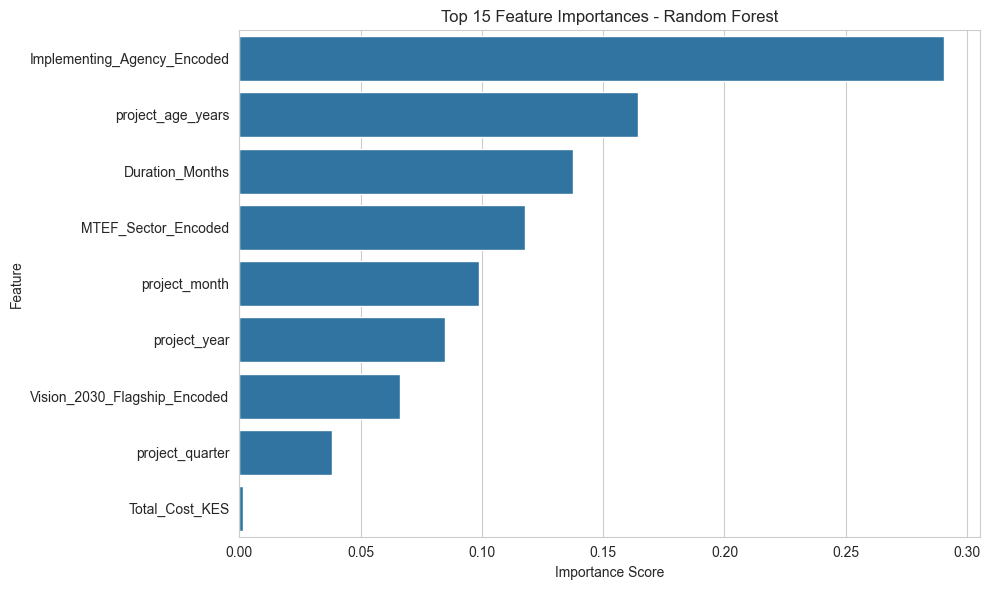

In [28]:
# Feature Importance Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp[:15], y=feature_imp.index[:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


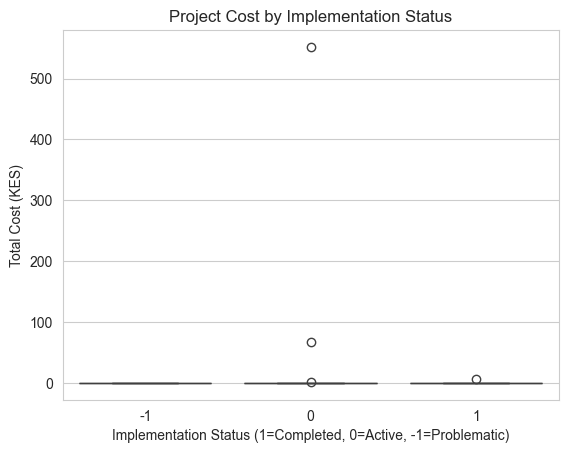

In [33]:
# Visualise Features vs Implementation Status
# Project Cost vs Status
sns.boxplot(data=df, x='Status_Encoded', y='Total_Cost_KES')
plt.title("Project Cost by Implementation Status")
plt.xlabel("Implementation Status (1=Completed, 0=Active, -1=Problematic)")
plt.ylabel("Total Cost (KES)")
plt.show()


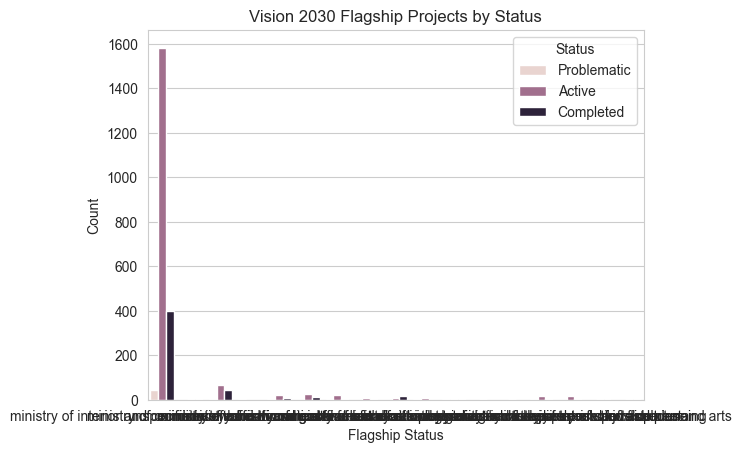

In [34]:
# Vision 2030 Flagship Status
sns.countplot(data=df, x='Vision_2030_Flagship', hue='Status_Encoded')
plt.title("Vision 2030 Flagship Projects by Status")
plt.xlabel("Flagship Status")
plt.ylabel("Count")
plt.legend(title="Status", labels=["Problematic", "Active", "Completed"])
plt.show()


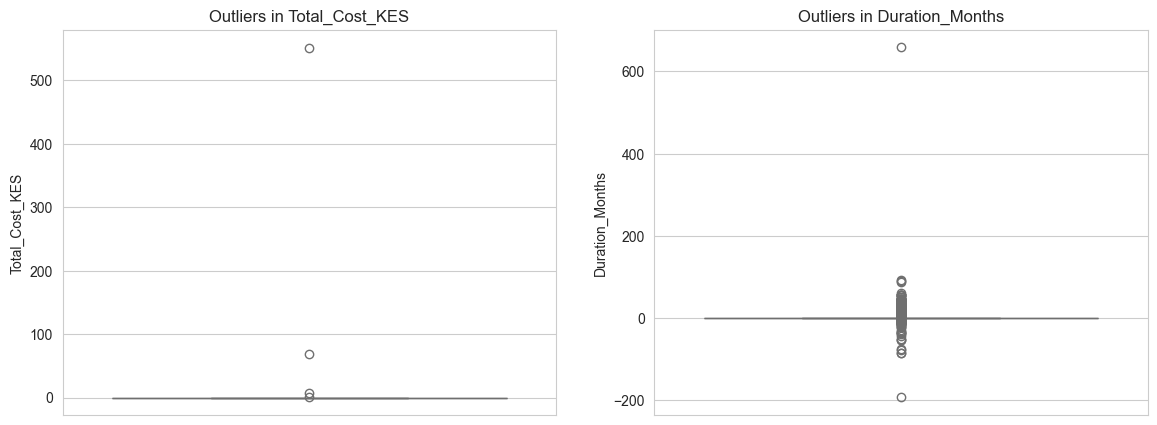

Total_Cost_KES       4
Duration_Months    584
dtype: int64

In [35]:
# Let us detect the existing outliers 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Selecting only numeric columns for outlier detection
numeric_cols = ["Total_Cost_KES", "Duration_Months"]

# Boxplot visualisation for outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Outliers in {col}")

plt.show()

# Identifying outliers using IQR method
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
outlier_condition = (df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))

# Count number of outliers per column
outliers_count = outlier_condition.sum()
outliers_count